# Hailey Chung ECE475 Project 4

In [14]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import os 
import sklearn

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.model_selection import GridSearchCV

# California Housing Dataset

S&P Letters Data
We collected information on the variables using all the block groups in California from the 1990 Census. In this sample a block group on average includes 1425.5 individuals living in a geographically compact area. Naturally, the geographical area included varies inversely with the population density. We computed distances among the centroids of each block group as measured in latitude and longitude. We excluded all the block groups reporting zero entries for the independent and dependent variables. The final data contained 20,640 observations on 9 variables. The dependent variable is ln(median house value).

		Bols	tols
INTERCEPT		11.4939	275.7518
MEDIAN INCOME		0.4790	45.7768
MEDIAN INCOME2		-0.0166	-9.4841
MEDIAN INCOME3		-0.0002	-1.9157
ln(MEDIAN AGE)		0.1570	33.6123
ln(TOTAL ROOMS/ POPULATION)	-0.8582	-56.1280
ln(BEDROOMS/ POPULATION)	0.8043	38.0685
ln(POPULATION/ HOUSEHOLDS)	-0.4077	-20.8762
ln(HOUSEHOLDS)		0.0477	13.0792

The file cadata.txt contains all the the variables. Specifically, it contains median house value, median income, housing median age, total rooms, total bedrooms, population, households, latitude, and longitude in that order. 

Reference

Pace, R. Kelley and Ronald Barry, ìSparse Spatial Autoregressions,î Statistics and Probability Letters, 33 (1997) 291-297.

The manuscript describing the data can be found at www.spatial-statistics.com. The data are also
available as Matlab files.

Contact kelley@spatial-statistics.com or kelley@pace.am if you have any further questions. Thanks.

In [16]:
# importing cadata.txt into df
filename = os.path.join(os.getcwd(), "cadata.txt")
features = ["median house value", "MedInc", "HouseAge", "total rooms", "total bedrooms", "Population", "households", "Latitude", "Longitude"]
df = pd.read_csv(filename, header = None, names = features, engine = 'python', delim_whitespace = True)
df

,median house value,MedInc,HouseAge,total rooms,total bedrooms,Population,households,Latitude,Longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.5603,25.0,1665.0,374.0,845.0,330.0,39.48,-121.09
20636,77100.0,2.5568,18.0,697.0,150.0,356.0,114.0,39.49,-121.21
20637,92300.0,1.7000,17.0,2254.0,485.0,1007.0,433.0,39.43,-121.22
20638,84700.0,1.8672,18.0,1860.0,409.0,741.0,349.0,39.43,-121.32


In [17]:
df["AveRooms"] = df["total rooms"] / df["households"]
df["AveBedrms"] = df["total bedrooms"] / df["households"]
df["AveOccup"] = df["Population"] / df["households"]
df.drop(columns = ["total rooms", "total bedrooms", "households"], inplace=True)
df

,median house value,MedInc,HouseAge,Population,Latitude,Longitude,AveRooms,AveBedrms,AveOccup
0,452600.0,8.3252,41.0,322.0,37.88,-122.23,6.984127,1.023810,2.555556
1,358500.0,8.3014,21.0,2401.0,37.86,-122.22,6.238137,0.971880,2.109842
2,352100.0,7.2574,52.0,496.0,37.85,-122.24,8.288136,1.073446,2.802260
3,341300.0,5.6431,52.0,558.0,37.85,-122.25,5.817352,1.073059,2.547945
4,342200.0,3.8462,52.0,565.0,37.85,-122.25,6.281853,1.081081,2.181467
...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.5603,25.0,845.0,39.48,-121.09,5.045455,1.133333,2.560606
20636,77100.0,2.5568,18.0,356.0,39.49,-121.21,6.114035,1.315789,3.122807
20637,92300.0,1.7000,17.0,1007.0,39.43,-121.22,5.205543,1.120092,2.325635
20638,84700.0,1.8672,18.0,741.0,39.43,-121.32,5.329513,1.171920,2.123209


In [18]:
y = df["median house value"]/100000
X = df.drop(columns = "median house value", inplace = False)
# "We randomly divided the dataset into a training set (80%) and a test set (20%)"
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 723)

In [19]:
model = xgb.XGBRegressor(max_depth = 3, learning_rate = 0.1, colsample_bytree=0.5, objective = "reg:pseudohubererror", n_estimators = 800, eval_metric = mean_absolute_error, alpha=5)
model.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)],verbose=0)
errors = model.evals_result()
train_error = np.array(errors['validation_0']['mean_absolute_error'])
test_error = np.array(errors['validation_1']['mean_absolute_error'])

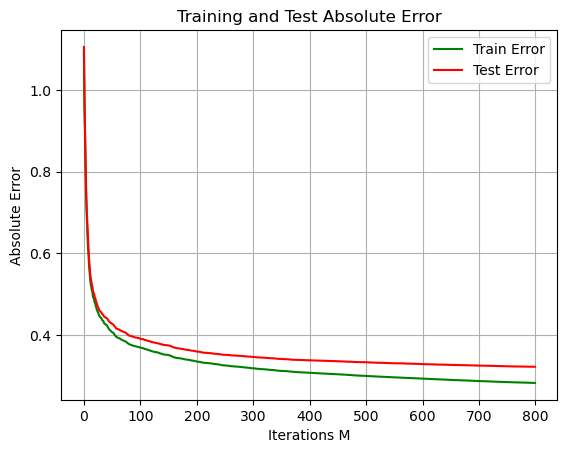

In [20]:
# Figure 10.13 Average-absolute error as a function of number of iterations for the California housing data
fig, ax = plt.subplots()
#M = range(0,800)
ax.plot(train_error, label = 'Train Error', color = 'green')
ax.plot(test_error, label = 'Test Error', color = 'red')
ax.set(xlabel='Iterations M', ylabel='Absolute Error',title='Training and Test Absolute Error')
ax.grid()
ax.legend()
plt.show()

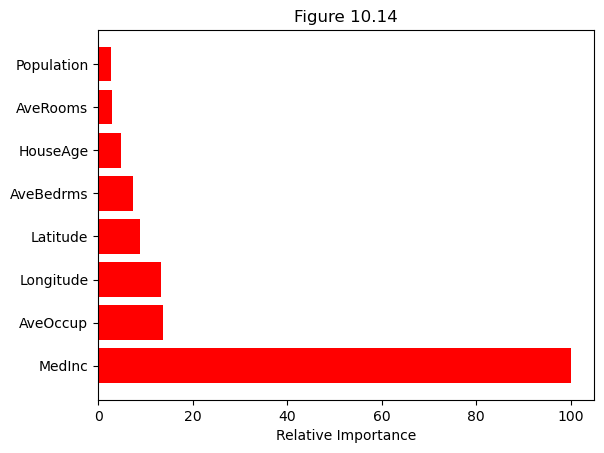

In [8]:
# Figure 10.14 Relative importance of the predictors for the california housing data
index = model.feature_importances_.argsort()
imp = model.feature_importances_[index][::-1]
relimp = (imp/max(imp))*100
feats = model.feature_names_in_[index][::-1]
plt.barh(feats,relimp, color = 'red')
plt.xlabel("Relative Importance")
plt.title("Figure 10.14")
plt.show()

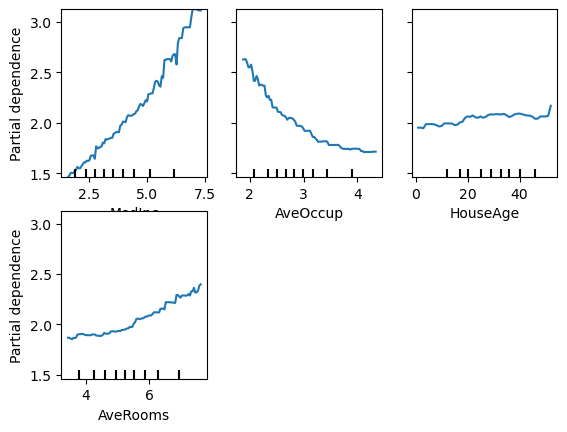

In [10]:
# FIGURE 10.15. Partial dependence of housing value on the nonlocation variables for the California housing data

features = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]
PartialDependenceDisplay.from_estimator(model, X_train, features)

/Users/hayoonchung/opt/anaconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:508: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(
/var/folders/zl/fxd66b555m5656g3sfpymcbr0000gn/T/ipykernel_9756/559285531.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


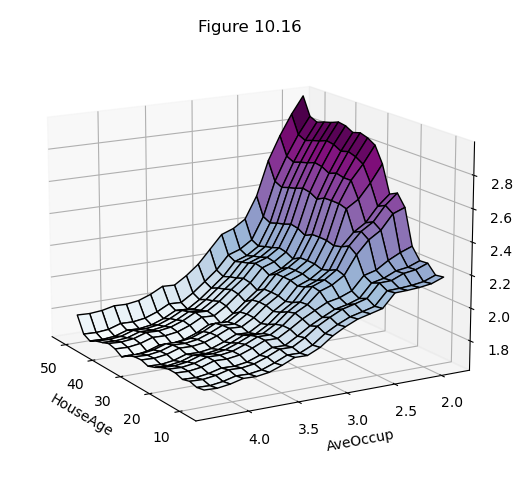

In [11]:
# Figure 10.16 Partial depencence of house value on median age and average occupancy
# looked at
# https://scikit-learn.org/0.22/auto_examples/inspection/plot_partial_dependence.html
# while doing this

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features2 = ["HouseAge","AveOccup"]
pdp, axes = partial_dependence(model, X_train, features2, grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')

ax.set(xlabel = "HouseAge", ylabel = "AveOccup")

ax.view_init(elev=15, azim=150)
plt.suptitle("Figure 10.16")
plt.subplots_adjust(top=0.9)

plt.show()